# Application Deployment

This notebook demonstrates the end-to-end process of building, testing, and deploying a banking virtual assistant using MLRun, LangChain, and Milvus for vector storage. It covers project setup, data ingestion for retrieval-augmented generation, application graph definition with guardrails and analysis steps, local testing, and deployment to Kubernetes. An interactive Gradio UI is also provided for user testing and demonstration.

![](images/03_application_deployment_architecture.png)

In [ ]:
!pip install -r requirements.txt

In [2]:
import os
import mlrun
mlrun.set_env_from_file("ai_gateway.env")
from langchain_milvus import Milvus
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv

load_dotenv("ai_gateway.env")

True

### Setup Project

Load the previously created project in the first notebook.

In [ ]:
project = mlrun.get_or_create_project("banking-agent", user_project=True)


Setting Source for the demo:
Project Source: None
> 2025-12-03 13:18:57,028 [info] Project loaded successfully: {"project_name":"banking-agent-admin"}


This tutorial uses [Milvus](https://milvus.io/api-reference/pymilvus/v2.4.x/About.md) on a local host for simplicity. To use Milvus without the local host, see [Manage Milvus Connections](https://milvus.io/docs/v2.1.x/manage_connection.md)

In [4]:
MILVUS_ARGS = {"uri": f"{os.getcwd()}/milvus_demo.db"}
MILVUS_ARGS

{'uri': '/Users/Daniel_Sabba/banking-agent-demo/milvus_demo.db'}

### Ingest Data for Vector Store Retrieval

This section covers the ingestion of banking knowledge base documents into the Milvus vector store. By loading and embedding markdown files containing general bank information, account details, and customer FAQs, we enable efficient retrieval-augmented generation for the virtual assistant. The following steps demonstrate how to load, embed, and store these documents for downstream use in the application.

In [5]:
vectorstore = Milvus(
    collection_name="banking_agent",
    embedding_function=OpenAIEmbeddings(model="text-embedding-3-small"),
    connection_args=MILVUS_ARGS,
    auto_id=True,
)

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


In [6]:
if not vectorstore.col:
    general_bank_info_kb = UnstructuredMarkdownLoader(
        "data/general_bank_info_kb.md"
    ).load()
    checking_savings_kb = UnstructuredMarkdownLoader(
        "data/checking_savings_kb.md"
    ).load()
    customer_faq = UnstructuredMarkdownLoader("data/customer_faq.md").load()
    pages = general_bank_info_kb + checking_savings_kb + customer_faq
    vectorstore.add_documents(pages)

In [7]:
milvus_artifact = project.log_artifact(
    "vectorstore", local_path=MILVUS_ARGS['uri'])

MILVUS_ARGS['uri'] = milvus_artifact.uri

In [8]:
vectorstore.col.num_entities

3

In [9]:
# vectorstore.col.drop()

### Define Application Serving Graph

The application serving graph orchestrates the flow of user queries through a series of modular steps:

- **Input Guardrails:**  
    Ensure only safe and relevant queries proceed by filtering out inappropriate or off-topic inputs.

- **Sentiment & Churn Analysis:**  
    Analyze user sentiment and predict churn propensity to enrich the context for downstream processing.

- **Context Building:**  
    Aggregate user information, sentiment, and churn data to construct a detailed context for the agent.

- **Response Generation:**  
    The agent leverages the built context and retrieval-augmented generation from the vector store to provide accurate and personalized responses.

This **graph-based architecture** enables robust, explainable, and extensible deployment of the banking virtual assistant, ensuring each step is modular and transparent for easier maintenance and future enhancements.

See real-time serving graphs in the [documentation](https://docs.mlrun.org/en/stable/serving/serving-graph.html) for more information.

In [10]:
banking_topic_guardail = project.get_function("banking-topic-guardrail-v2")
toxicity_guardrail = project.get_function("toxicity-guardrail")
churn_model = project.get_function("serving")

In [11]:
from pathlib import Path

In [12]:
requirements = Path("requirements.txt").read_text().split()

In [13]:
agent_graph = project.set_function(
    name="banking-agent",
    func="src/functions/agent_graph_v2.py",
    kind="serving",
    image="mlrun/mlrun",
    # requirements_file="requirements.txt",
)
agent_graph.spec.build.with_commands(
    commands=[
        f'pip install --index-url https://download.pytorch.org/whl/cpu --extra-index-url https://pypi.org/simple {" ".join(requirements)}'
    ],
    overwrite=True
)
# Mount storage for vector store
# Should use client/server architecture in production
if not mlrun.mlconf.is_ce_mode():
    agent_graph.apply(mlrun.auto_mount())

I0000 00:00:1764760738.989865 35979521 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


In [14]:
MILVUS_ARGS["uri"]

'store://artifacts/banking-agent-admin/vectorstore#0@eb3715ecc12f2bccae99c082d212d87af69edda2^0059b243081eadc7b51c84df04bb3b30f6de7769'

In [15]:
graph = agent_graph.set_topology("flow", engine="async", exist_ok=True)
guardrails_router = graph.add_step(
    "*ParallelRunMerger",
    name="input-guardrails",
    output_key="guardrails_output",
    extend_event=True,
)

guardrails_router.add_route(
    key="banking-topic-guardrail",
    class_name="mlrun.serving.remote.RemoteStep",
    method="POST",
    url=banking_topic_guardail.get_url(),
)
guardrails_router.add_route(
    key="toxicity-guardrail",
    class_name="mlrun.serving.remote.RemoteStep",
    method="POST",
    url=toxicity_guardrail.get_url(),
)
graph.add_step(
    name="guardrail-filter",
    class_name="GuardrailsChoice",
    mapping={"True": "accept", "False": "reject"},
    after="input-guardrails",
)
graph.add_step(name="accept", handler="accept", after="guardrail-filter")

input_analysis_router = graph.add_step(
    "*ParallelRunMerger",
    name="input-analysis",
    output_key="input_analysis_output",
    after="accept",
    extend_event=True,
)
input_analysis_router.add_route(
    key="sentiment-analysis",
    class_name="SentimentAnalysisModelServer",
    result_path="sentiment_analysis_output",
)
input_analysis_router.add_route(
    key="churn-prediction",
    class_name="ChurnModelServer",
    dataset=f"store://datasets/{project.name}/data-process-data_test#0:latest",
    label_column="churn",
    endpoint_url=project.get_function('serving', tag='latest').get_url(),
    churn_mappings={"high": 0.50, "medium": 0.20, "low": 0},
    result_path="churn_model_output",
)

graph.add_step(
    name="build-context",
    class_name="BuildContext",
    context_mappings={
        "name": "name",
        "sentiment": 'input_analysis_output."sentiment-analysis".outputs[0]',
        "churn": 'input_analysis_output."churn-prediction".outputs[0]',
    },
    output_key="formatted_prompt",
    prompt="""
    This is context about the user and their query:
    <user_context>
    name: {name}
    sentiment: {sentiment}
    churn propensity percentage: {churn}
    </user_context>

    If they have a high churn propensity consider asking them if would like to escalate to a human operator.
    Do not offer to escalate for low churn propensity.
    Do NOT mention the churn propensity but use it to craft your response.
    Use the sentiment to craft your response.
    """,
    after="input-analysis",
)
graph.add_step(
    name="banking-agent",
    class_name="BankingAgent",
    model_name="gpt-4o-mini",
    system_prompt="You are a helpful assistant for IGZ Bank. Respond in a concise, but detailed way. Use web search if the customer asks about other banks or external information.",
    result_path="banking-agent",
    after="build-context",
    prompt_input_key="formatted_prompt",
    messages_input_key="inputs",
    vector_db_collection="banking_agent",
    vector_db_args=MILVUS_ARGS,
    vector_db_description="Use this to answer any questions about general bank info like locations, hours, guidelines for opening savings/checking accounts, APY for savings/checking, as well as general FAQ like resetting passowrds, ATM fees, setting up direct deposit, etc.",
)
graph.add_step(name="reject", handler="reject", after="guardrail-filter")

graph.add_step(
    name="output", handler="responder", after=["banking-agent", "reject"]
).respond()

I0000 00:00:1764760739.235646 35979521 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


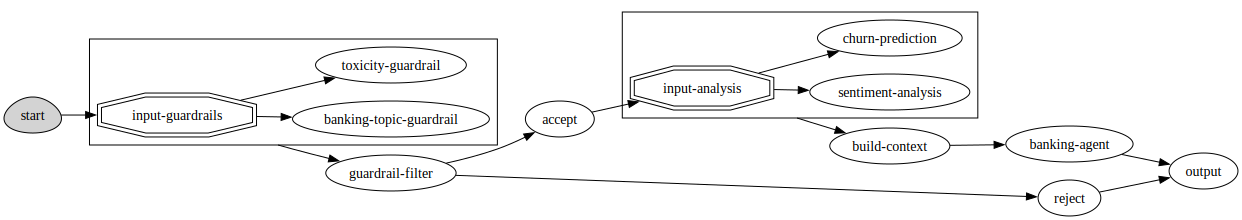

In [16]:
graph.plot(rankdir="LR")

In [17]:
# mock = agent_graph.to_mock_server()

In [18]:
HIGH_PROPENSITY_CHURN_USER_ID = 32
LOW_PROPENSITY_CHURN_USER_ID = 2296

### Test Input Guardrails

In [19]:
def _format_question(question: str, role: str = "user"):
    return {"role": role, "content": question}

Question the agent CANNOT answer - rejects input

In [ ]:
resp = mock.test(
    path="/",
    body={
        "name": "John",
        "inputs": [_format_question("how to make hot dogs?")],
        "user_id": LOW_PROPENSITY_CHURN_USER_ID,
    },
)
print(resp["outputs"][0])

Question the agent CANNOT answer - rejects input

In [ ]:
resp = mock.test(
    path="/",
    body={
        "name": "John",
        "inputs": [_format_question("i hate you")],
        "user_id": LOW_PROPENSITY_CHURN_USER_ID,
    },
)
print(resp["outputs"][0])

As a banking agent, I am not allowed to talk on this subject. Is there anything else I can help with?


### Test Banking Agent - Sentiment Analysis + Churn Propensity

Standard Q&A with neutral sentiment and low churn

In [ ]:
resp = mock.test(
    path="/",
    body={
        "name": "John",
        "inputs": [_format_question("how to apply for checking account?")],
        "user_id": LOW_PROPENSITY_CHURN_USER_ID,
    },
)
print(resp["banking-agent"]["outputs"]["response"][0])

To apply for a checking account with IGZ Bank, you can follow these steps:

### Eligibility Requirements:
1. **Age**: Must be 18 years or older.
2. **ID**: Provide a valid government-issued photo ID (like a driver's license or passport).
3. **SSN/TIN**: You'll need a Social Security Number or Taxpayer Identification Number.

### Required Documents:
- **Proof of Address**: This can be a utility bill or lease agreement dated within the last 60 days.
- **Initial Deposit**: A minimum of $50 for checking accounts.

### Account Options:
- **Basic Checking**: 
  - Monthly Fee: $5 (waived with a balance of $500+)
  - APY: 0.01%
- **Rewards Checking**:
  - Monthly Fee: $10
  - Cashback: Up to 1.5% on debit card purchases
  - APY: 0.10%

### Application Process:
1. **Online**: 
   - Fill out the application form on the IGZ Bank website.
   - Upload the necessary documents and e-sign the agreement.
2. **In-Branch**: 
   - Complete a paper application and present your documents to a bank represent

Standard Q&A with negative sentiment and low churn

In [ ]:
resp = mock.test(
    path="/",
    body={
        "name": "John",
        "inputs": [
            _format_question(
                "how to apply for checking account? I keep trying but I'm really frustrated"
            )
        ],
        "user_id": LOW_PROPENSITY_CHURN_USER_ID,
    },
)
print(resp["banking-agent"]["outputs"]["response"][0])

I understand how frustrating it can be to navigate the application process for a checking account. Here's a clear guide to help you apply effectively:

### Eligibility Requirements
1. **Age**: Must be 18 years or older.
2. **ID**: A valid government-issued photo ID (driver’s license or passport).
3. **Tax Information**: Social Security Number (SSN) or Taxpayer Identification Number (TIN).

### Required Documents
- **Proof of Address**: A utility bill or lease agreement dated within the last 60 days.
- **Initial Deposit**: Minimum of $50.

### Application Process
You have two options to apply:
1. **Online**:
   - Fill out the application form on our website.
   - Upload the necessary documents.
   - E-sign the agreement.

2. **In-Branch**:
   - Visit a local branch and fill out a paper form.
   - Present your documents to a representative.

### Account Activation
- **Online Applications**: Typically activated instantly, and your debit card will be mailed to you within 5-7 business days.

Standard Q&A with low sentiment and high churn - note that the model offers to escalate to a human operator. This kind of behavior is customizable depending on the input guardrails and input analysis.

In [ ]:
resp = mock.test(
    path="/",
    body={
        "name": "Alice",
        "inputs": [
            _format_question(
                "how to apply for checking account? I keep trying but I'm really frustrated"
            )
        ],
        "user_id": HIGH_PROPENSITY_CHURN_USER_ID,  # <-- High churn propensity user
    },
)
print(resp["banking-agent"]["outputs"]["response"][0])

I understand how frustrating it can be to navigate the process of applying for a checking account. Here’s a step-by-step guide to help make it easier for you:

### Eligibility Requirements:
1. **Age:** You must be at least 18 years old.
2. **ID:** A valid government-issued photo ID (like a driver's license or passport).
3. **Social Security Number (SSN):** You'll need either your SSN or a Taxpayer Identification Number (TIN).

### Required Documents:
- **Proof of Address:** A utility bill or lease agreement dated within the last 60 days.
- **Initial Deposit:** At least $50 for a checking account.

### Account Options:
- **Basic Checking:** 
  - Monthly fee: $5 (waived with balance over $500).
  - APY: 0.01%
  
- **Rewards Checking:**
  - Monthly fee: $10.
  - APY: 0.10% plus cashback on purchases.

### Application Process:
- **Online:** 
  - Fill out the application form, upload the necessary documents, and e-sign the agreement.
- **In-Branch:** 
  - Complete a paper application and pr

Standard multi-turn Q&A

In [ ]:
resp = mock.test(
    path="/",
    body={
        "name": "Alice",
        "inputs": [
            {"role": "user", "content": "Hi—how do I open a checking account?"},
            {
                "role": "assistant",
                "content": "To open a checking account, you need two forms of ID and a minimum deposit of $25.",
            },
            {"role": "user", "content": "Is it possible to get cashback rewards?"},
        ],
        "user_id": HIGH_PROPENSITY_CHURN_USER_ID,  # <-- High churn propensity user
    },
)
print(resp["banking-agent"]["outputs"]["response"][0])

Yes, IGZ Bank offers a "Rewards Checking" account that provides cashback rewards. You can earn up to 1.5% cashback on debit card purchases with this checking account. The monthly fee for this account is $10, which can be waived with a minimum balance. 

If you're interested in this account type or need assistance with the application process, please let me know!


### Full Outputs

Below is the comprehensive output from the application graph. This includes all intermediate and final results: user input, guardrails decisions, input analysis (such as sentiment and churn predictions), any tool calls, and the generated response from the model. Use this section to trace the end-to-end flow and understand how each component contributes to the final answer.

In [ ]:
resp

{'name': 'Alice',
 'inputs': [{'role': 'user',
   'content': 'Hi—how do I open a checking account?'},
  {'role': 'assistant',
   'content': 'To open a checking account, you need two forms of ID and a minimum deposit of $25.'},
  {'role': 'user', 'content': 'Is it possible to get cashback rewards?'}],
 'user_id': 32,
 'background_task_state': failed,
 'guardrails_output': {'toxicity-guardrail': {'id': '0389bacb-b225-4f5b-b2cf-ffd964129397',
   'model_name': 'toxicity-guardrail',
   'outputs': [True],
   'timestamp': '2025-12-03 10:21:31.432434+00:00',
   'model_endpoint_uid': '167fbcfa5c4b4126ac572ea9f58ed219'},
  'banking-topic-guardrail': {'id': '11faa2f6-585b-423e-9016-f1ef66d9f71c',
   'model_name': 'banking-topic-guardrail',
   'outputs': ['True'],
   'timestamp': '2025-12-03 10:21:31.440900+00:00',
   'model_endpoint_uid': 'ff2b8b3eaa264a7fa717394abc718bb0'}},
 'input_analysis_output': {'churn-prediction': {'id': 'cfb1695cbf2344ae8019c5c5aa222b61',
   'model_name': 'churn-predicti

### Deploy to K8s

Deploy the banking agent application to a production-ready Kubernetes endpoint. This enables robust, scalable, and highly available access for integration with real-world applications. Kubernetes orchestration ensures automatic scaling and reliability based on demand.

In [ ]:
project.deploy_function(agent_graph)

> 2025-12-03 13:20:04,340 [info] Starting remote function deploy
2025-12-03 11:20:05  (info) Deploying function
2025-12-03 11:20:05  (info) Building
2025-12-03 11:20:06  (info) Staging files and preparing base images
2025-12-03 11:20:06  (warn) Using user provided base image, runtime interpreter version is provided by the base image
2025-12-03 11:20:06  (info) Building processor image


In [ ]:
resp = agent_graph.invoke(
    path="/",
    body={
        "name": "Alice",
        "inputs": [
            {"role": "user", "content": "Hi—how do I open a checking account?"},
            {
                "role": "assistant",
                "content": "To open a checking account, you need two forms of ID and a minimum deposit of $25.",
            },
            {"role": "user", "content": "Is it possible to get cashback rewards?"},
        ],
        "user_id": HIGH_PROPENSITY_CHURN_USER_ID,  # <-- High churn propensity user
    },
)
print(resp["banking-agent"]["outputs"]["response"][0])

Yes, IGZ Bank offers a Rewards Checking account that provides cashback on debit card purchases. You'll earn up to 1.5% cashback, and the account comes with a monthly fee of $10. This fee can be waived if you maintain a balance of $500 or more.

If you're interested, you can open this account online or in-branch. Let me know if you need more information!


### Application UI

The Streamlit UI offers an interactive environment to test and explore the banking agent's capabilities. Its main features include:

- **Chat Window:**  
    Engage in a conversational interface where you can enter questions and receive responses from the assistant, simulating real user interactions.

- **Tool Usage Visualization:**  
    When the agent invokes external tools or APIs (such as retrieving information from the vector store), these actions are surfaced in the chat, allowing you to see when and how tools are used.

- **Intermediate Graph Steps:**  
    The UI displays outputs from key stages of the application graph, including:
    - **Input Guardrails:**  
        - *Toxicity Guardrail Passed* — Indicates if the input passes the toxicity filter.
        - *Banking Topic Guardrail Passed* — Shows whether the query is relevant to banking topics.
    - **Input Analysis:**  
        - *Sentiment Analysis* — Reveals the detected sentiment of the user's input.
        - *Churn Prediction* — Estimates the user's propensity to leave, which can influence the assistant's response.

This transparent design helps users trace the end-to-end flow of their queries, understand decision points, and gain insight into how each system component contributes to the final answer.

![](images/banking_agent_ui.png)

In [ ]:
!tar -czvf frontend_ui.tar.gz ./src/functions/frontend_ui.py

I0000 00:00:1756935047.797779 1273114 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


./src/functions/frontend_ui.py


In [ ]:
frontend_source = project.log_artifact("frontend_source", local_path="frontend_ui.tar.gz", upload=True)

In [ ]:
ui_fn = project.set_function(
    name="frontend",
    kind="application",
    image="mlrun/mlrun",
    requirements=["streamlit==1.49.1"]
)

In [ ]:
API_URL = agent_graph.get_url()
API_URL

'http://nuclio-banking-agent-banking-agent.default-tenant.svc.cluster.local:8080'

In [ ]:
ui_fn.set_env("API_URL", API_URL)
ui_fn.with_source_archive(frontend_source.target_path, pull_at_runtime=False)
ui_fn.set_internal_application_port(8000)
ui_fn.spec.command = "streamlit"
ui_fn.spec.args = ["run", "--server.port", "8000", "/home/mlrun_code/src/functions/frontend_ui.py"]

In [ ]:
ui_fn.deploy(with_mlrun=False, create_default_api_gateway=False)
ui_fn.create_api_gateway(
    name="banking-agent-ui",
    path="/",
    direct_port_access=True,
    ssl_redirect=True,
    set_as_default=False,
    authentication_mode="none"
)